In [1]:
import sys
import pandas as pd
import numpy as np
from numpy import log
from pandas import Series

from statsmodels.tsa.stattools import adfuller
#from pandas.core import datetools

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
print(sys.version)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


## (1) Trend
Trend, as its name suggests, is the overall direction of the data. Trends indicate a slow change in the behavior of a variable in time, in its average over a long period.

Although consecutive measurements may increase or decrease on an opposed direction, the overall behavior persists over time. An example of this is climate; in the Northern Hemisphere, temperatures might decrease by several degrees in May from one day to the next day, but the overall behavior is warming towards the summer.

__Flotation cell__
Description:	Data from a zinc-lead flotation cell measured on 5 variables; recorded from the PLCs.

Data source:	Actual data from a mining company.

Data shape:	2922 rows and 5 columns

In [3]:
location = r'https://raw.githubusercontent.com/Santanukolkata/Data_Science/master/datasets/flotation-cell.csv'

In [4]:
df_fcdata  = pd.read_csv(location, index_col=0)

In [5]:
df_fcdata.shape

(2922, 5)

In [6]:
df_fcdata.head()

,Feed rate,Upstream pH,CuSO4 added,Pulp level,Air flow rate
Date and time,,,,,
15/12/2004 19:57:01,341.049347,10.820513,7.995605,24.443470,2.802198
15/12/2004 19:57:31,274.270782,10.827351,7.786569,27.819294,2.798535
15/12/2004 19:58:01,334.836761,10.854701,7.655922,30.335533,2.805861
15/12/2004 19:58:32,323.605927,10.885470,7.838828,30.663738,2.802198
15/12/2004 19:59:03,322.341309,10.851282,7.995605,30.288647,2.805861


In [14]:
selected = df_fcdata.loc[(df_fcdata.index > '16/12/2004 20:16:00') & 
                         (df_fcdata.index < '16/12/2004 20:35:00'),
                         'Feed rate']

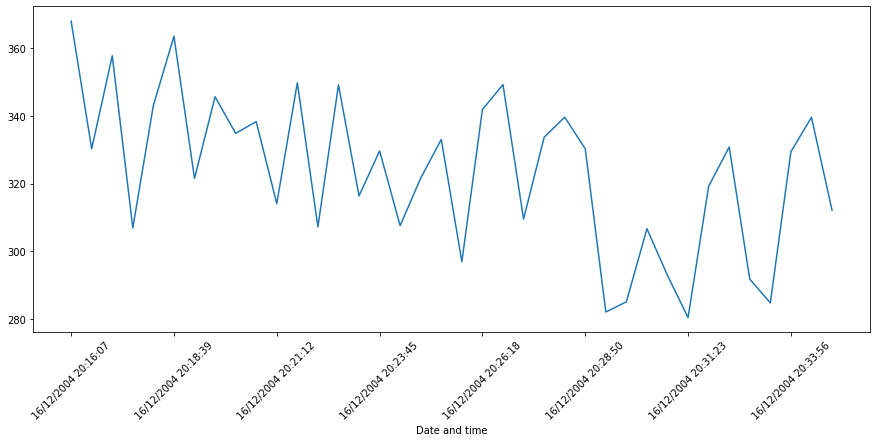

In [15]:
selected.plot(rot=45);

- we will be using a __polynomial fitting function, polyfit()__ to find the best adjusting first degree polynomial and its fitting error. 

- A first degree polynomial has 2 parameters, that we can call the _slope and the offset_. 

- If the slope is different from zero, then there is a trend in the data

- the residuals (that gives us a measure of the fitting error and that we will convert into the Normalized Mean Squared Error (NRMSE), that gives us a measurement of the error between 0 and 1)

In [12]:
type(selected)

pandas.core.series.Series

In [13]:
len(selected.index)

2922

In [16]:
range(len(selected.index))

range(0, 38)

In [17]:
coefficients, residuals, _, _, _ = np.polyfit(range(len(selected.index)),
                                              selected,
                                              1,
                                              full=True)

In [18]:
coefficients

array([ -1.074735  , 343.38421087])

In [19]:
residuals

array([14669.19651345])

In [20]:
mse = residuals[0]/(len(selected.index))

nrmse = np.sqrt(mse)/(selected.max() - selected.min())

print('Slope ' + str(coefficients[0]))
print('NRMSE: ' + str(nrmse))

Slope -1.074734997626719
NRMSE: 0.2247756782437052


- We can see that a negative trend is detected, of about -1.73 units of the Feed rate per time interval (in this dataset, the time interval is 30 seconds), 

- with an error of about 22.4%. 

We can now draw the trend line. Remember that the trend line is a polynomial in the Ax+B form:

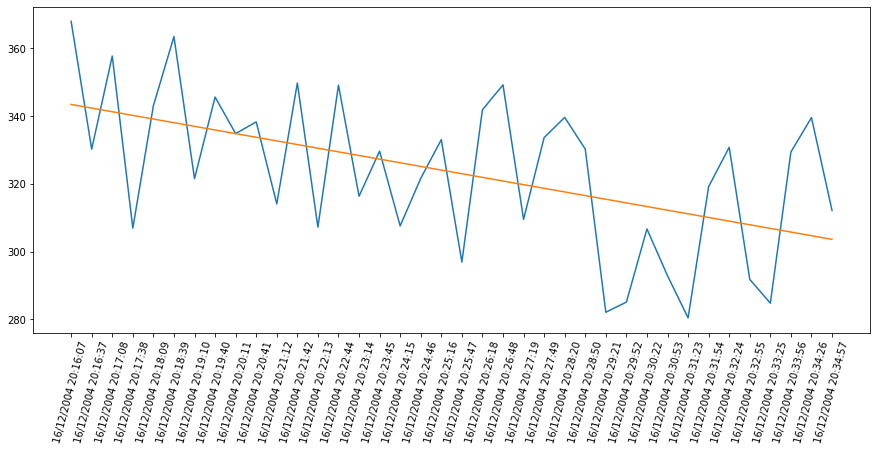

In [22]:
plt.xticks(rotation=75)
plt.plot(selected)
plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(selected))]);

In [23]:
# define a function to check trend and plot

def detect_trend (X_df):
    coefficients, residuals, _, _, _ = np.polyfit(range(len(X_df)),
                                                              X_df,
                                                              1,
                                                              full=True)

    mse = residuals[0]/(len(X_df))
    nrmse = np.sqrt(mse)/(X_df.max() - X_df.min())

    print('Slope ' + str(coefficients[0]))
    print('NRMSE: ' + str(nrmse))

    plt.xticks(rotation=90)
    plt.plot(X_df)
    plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(X_df))]);

## Example 2:

In [24]:
from scipy.signal import detrend

In [25]:
detrend_scipy_data = detrend(selected)

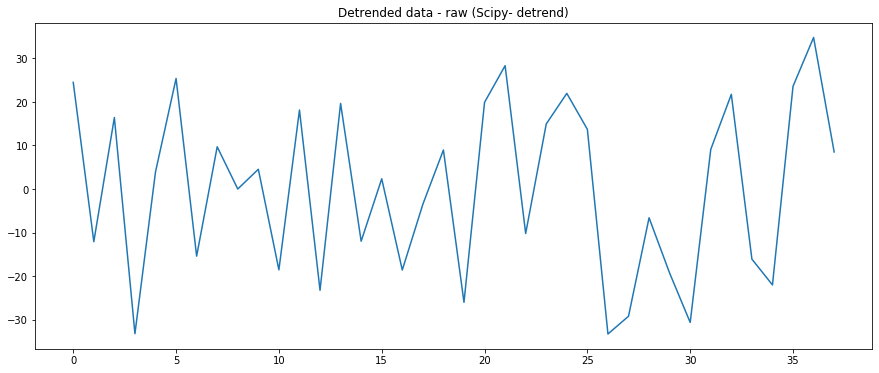

In [26]:
plt.title("Detrended data - raw (Scipy- detrend)")
plt.plot(detrend_scipy_data)

Slope -3.5377056488658307e-15
NRMSE: 0.2883630755944362


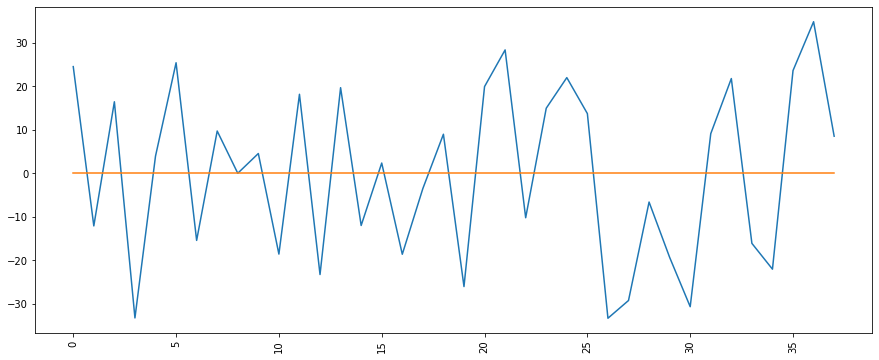

In [27]:
detect_trend(detrend_scipy_data)

## Trend - example 3 - detect and detrend (scipy and differencing)

In [28]:
df_sales_data  = pd.read_csv('https://raw.githubusercontent.com/Santanukolkata/Data_Science/master/datasets/shampoo_sales.csv', index_col=0)

In [29]:
print(df_sales_data.shape)
df_sales_data.head()

(36, 1)


,Sales of shampoo over a three year period
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


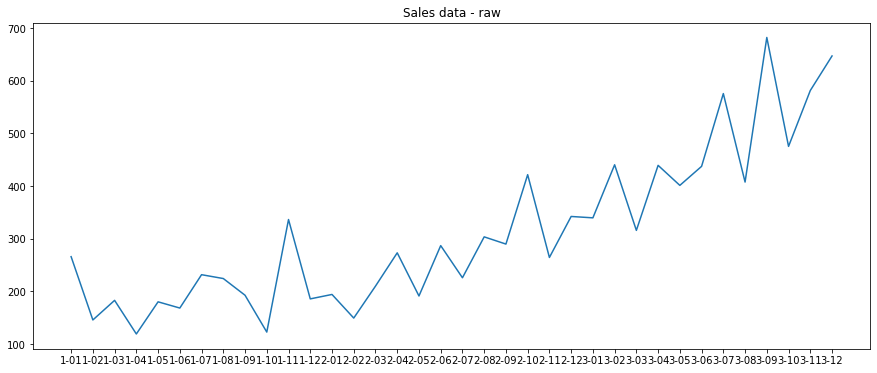

In [30]:
plt.title("Sales data - raw")
plt.plot(df_sales_data);

Slope [12.07907336]
NRMSE: Sales of shampoo over a three year period    0.135584
dtype: float64


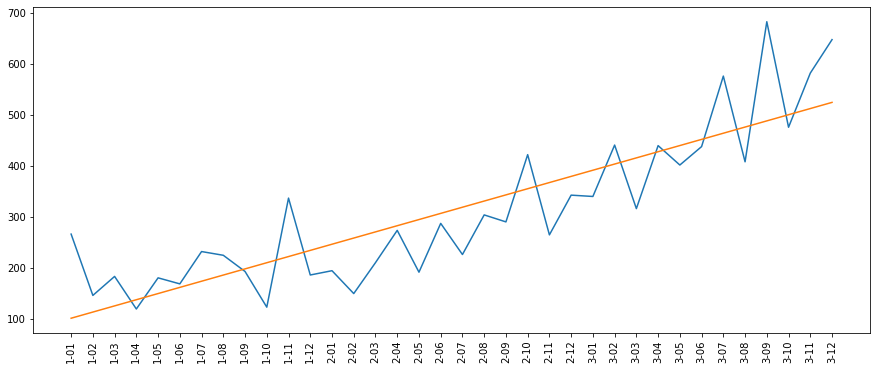

In [31]:
# check if the trend is there 
detect_trend(df_sales_data)

In [32]:
# Method 1 : detrend - using scipy
detrend_scipy_sales_data = detrend(df_sales_data)

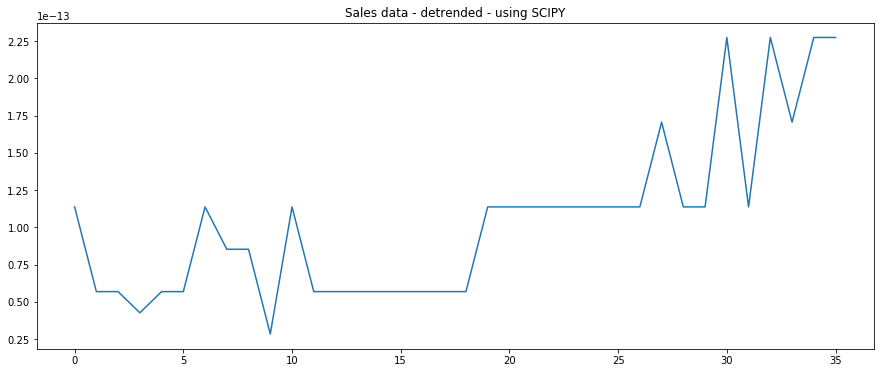

In [33]:
plt.title("Sales data - detrended - using SCIPY")
plt.plot(detrend_scipy_sales_data);

Slope [3.94867894e-15]
NRMSE: 0.1822446895744643


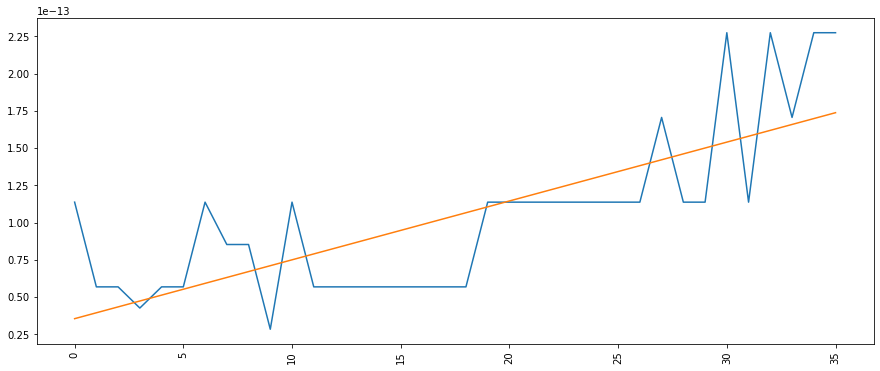

In [34]:
# check if the trend is there 
detect_trend(detrend_scipy_sales_data)

In [35]:
# Method 2 : detrend - differencing
X    = df_sales_data.values

diff = list()

for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)

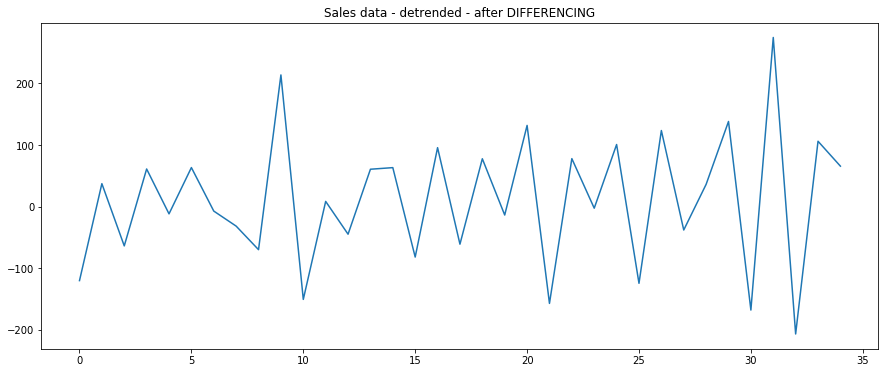

In [36]:
plt.title("Sales data - detrended - after DIFFERENCING")
plt.plot(diff);

In [37]:
diff = np.array(diff)

Slope [1.45058824]
NRMSE: 0.221758405166822


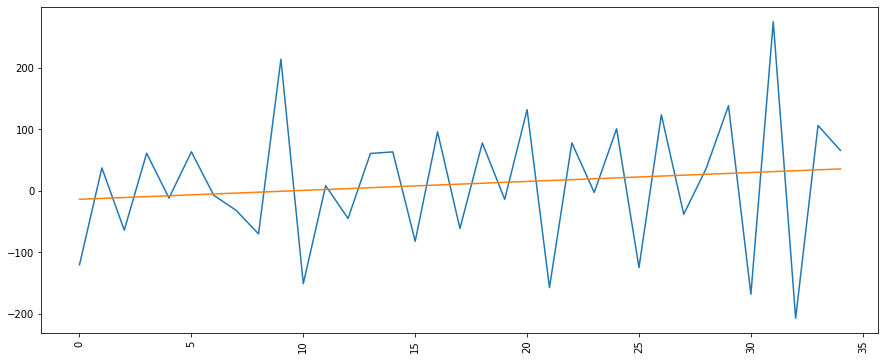

In [38]:
# check if the trend is there 
detect_trend(diff)

## Example 4:

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
df_sales_data  = pd.read_csv('https://raw.githubusercontent.com/Santanukolkata/Data_Science/master/datasets/shampoo_sales.csv', index_col=0)

In [41]:
X = [i for i in range(0, len(df_sales_data))]
X = np.reshape(X, (len(X), 1))

In [42]:
y = df_sales_data.values

In [43]:
# instatiate the linear reg model
model = LinearRegression()

In [44]:
# fit the data
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
# calculate predicted values
y_pred = model.predict(X)

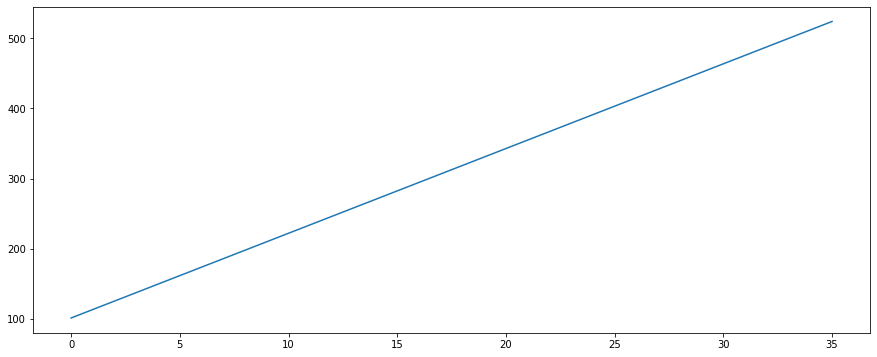

In [46]:
# plot the trend
plt.plot(y_pred);

Slope [-7.35500775e-16]
NRMSE: 0.25179423797379263


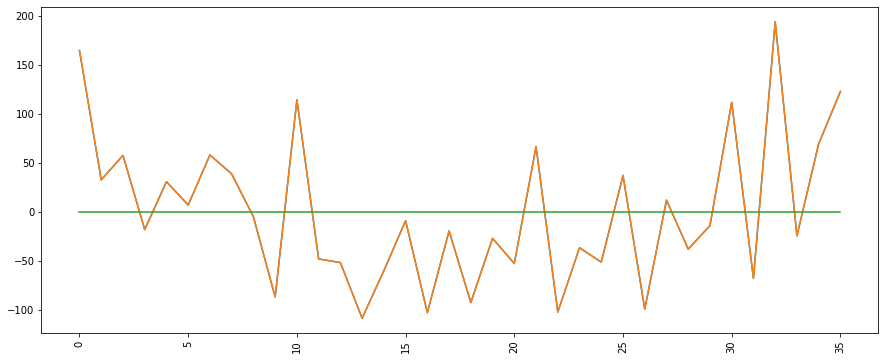

In [47]:
# detrend
detrended = [y[i] - y_pred[i] for i in range(0, len(df_sales_data))]

# plot detrended
plt.plot(detrended)

# check if the trend is there 
detect_trend(np.array(detrended))